## Create Chunked Dataset

In [10]:
import os
import getpass

from datasets import load_dataset, DatasetDict
from huggingface_hub import login
from transformers import AutoTokenizer
from dotenv import load_dotenv
import matplotlib.pyplot as plt


In [11]:

load_dotenv('.envrc')
if 'HF_TOKEN' in os.environ:
    login(token=os.environ['HF_TOKEN'])
else:
    login(token=getpass.getpass('Huggingface token: '))

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [12]:
# DATASET_REPO = 'roneneldan/TinyStories'
# STORY_KEY = 'text'
DATASET_REPO = 'SimpleStories/SimpleStories'
STORY_KEY = 'story'

CHUNK_LENGTH = 128

TOKENIZER_MODEL = 'SimpleStories/SimpleStories-35M'
TRAIN_SPLIT_PERCENTAGE = 4

In [ ]:

dataset = load_dataset(DATASET_REPO, split='train')
print('Total rows:', len(dataset))


In [ ]:
# tokenize the dataset  
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_MODEL)
tokenizer.pad_token = tokenizer.eos_token
def tokenize_function(examples):
    return tokenizer(examples[STORY_KEY], truncation=False, padding='do_not_pad')
tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=dataset.column_names).select_columns(['input_ids'])

tokenized_dataset

Dataset({
    features: ['input_ids'],
    num_rows: 2115696
})

In [ ]:

train_dataset, val_dataset = tokenized_dataset.train_test_split(
    test_size=TRAIN_SPLIT_PERCENTAGE / 100,
    seed=42,
).values()

def chunk_dataset_with_map(dataset, token_column='input_ids', chunk_length=CHUNK_LENGTH):
    """
    Memory-efficient version using dataset.map() and batched processing.
    """
    
    def chunk_batch(batch):
        chunked_batch = {col: [] for col in batch.keys()}
        
        for i in range(len(batch[token_column])):
            tokens = batch[token_column][i]
            token_count = len(tokens)
            num_chunks = token_count // chunk_length
            
            for chunk_idx in range(num_chunks):
                start_idx = chunk_idx * chunk_length
                end_idx = start_idx + chunk_length
                chunk_tokens = tokens[start_idx:end_idx]
                
                # Add chunk to batch
                for col in batch.keys():
                    if col == token_column:
                        chunked_batch[col].append(chunk_tokens)
                    else:
                        chunked_batch[col].append(batch[col][i])
        
        return chunked_batch
    
    # Use map with batched=True for memory efficiency
    chunked_dataset = dataset.map(
        chunk_batch,
        batched=True,
        remove_columns=dataset.column_names,  # Remove original columns
        batch_size=1000,  # Adjust based on your memory constraints
    )
    
    return chunked_dataset
chunked_dataset_train = chunk_dataset_with_map(train_dataset, chunk_length=CHUNK_LENGTH)
chunked_dataset_val = chunk_dataset_with_map(val_dataset, chunk_length=CHUNK_LENGTH)

In [ ]:
print("Train dataset length:", len(chunked_dataset_train))
print("Validation dataset length:", len(chunked_dataset_val))
DS_REPO_NAME = DATASET_REPO.replace('/', '-') + f'-chunked-{CHUNK_LENGTH}'
train_dataset.push_to_hub(f"MikiV/{DS_REPO_NAME}-train", private=True)
val_dataset.push_to_hub(f"MikiV/{DS_REPO_NAME}-val", private=True)



Train dataset length: 3653646
Validation dataset length: 152426


Uploading the dataset shards:   0%|          | 0/5 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

  2025-11-04T16:00:51.964402Z ERROR  Python exception updating progress:, error: PyErr { type: <class 'zmq.error.ZMQError'>, value: ZMQError('Too many open files'), traceback: Some(<traceback object at 0x7faacdd53280>) }, caller: "src/progress_update.rs:313"
    at /home/conda/feedstock_root/build_artifacts/bld/rattler-build_hf-xet_1758319744/work/error_printer/src/lib.rs:28



Cancellation requested; stopping current tasks.


KeyboardInterrupt: 

## Dataset Exploration

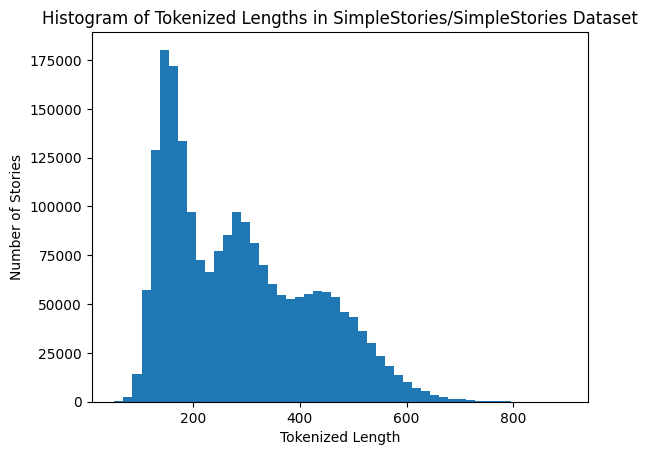

In [ ]:
# Historgram of tokenized lengths
lengths = [len(x) for x in tokenized_dataset['input_ids']]
plt.hist(lengths, bins=50)
plt.xlabel('Tokenized Length')
plt.ylabel('Number of Stories')
plt.title(f'Histogram of Tokenized Lengths in {DATASET_REPO} Dataset')
plt.show()

In [ ]:
total_tokens_train = len(chunked_dataset_train)*CHUNK_LENGTH/1e6
total_tokens_val = len(chunked_dataset_val)*CHUNK_LENGTH/1e6
total_tokens_original = sum(lengths)/1e6
print(f"Total available tokens = {total_tokens_original}M tokens")
print(f"Total tokens in chunked dataset (train) = {total_tokens_train}M tokens")
print(f"Total tokens in chunked dataset (test) = {total_tokens_val}M tokens")
print(f"We are left with {(total_tokens_train + total_tokens_val)/total_tokens_original * 100}% of the original tokens (train)")

Total available tokens = 608.617592M tokens
Total tokens in chunked dataset (train) = 467.666688M tokens
Total tokens in chunked dataset (test) = 19.510528M tokens
We are left with 80.04652221751752% of the original tokens (train)


In [ ]:
for thresh in [64, 128, 256, 512]:
    x = sum(l >= thresh for l in lengths) / len(lengths) * 100
    print(f"{x}% of stories are at least {thresh} tokens")

99.9950370941761% of stories are at least 64 tokens
94.04508020055812% of stories are at least 128 tokens
52.60907049027838% of stories are at least 256 tokens
7.031728565918733% of stories are at least 512 tokens


In [ ]:
tokenizer.get_vocab()

{'##ress': 3127,
 '##room': 2681,
 'pu': 1303,
 'swimming': 2706,
 '##flowers': 3622,
 '##igg': 1139,
 'silent': 1871,
 'ruin': 3830,
 'okay': 1857,
 '##ack': 284,
 '##lex': 372,
 'reflected': 3644,
 'sche': 4012,
 '##ive': 2105,
 'vowed': 3274,
 'gri': 2187,
 '##ap': 897,
 'tou': 1069,
 'im': 643,
 'stretched': 2765,
 'reef': 3635,
 'ticked': 3137,
 'rocky': 3443,
 'prepared': 2233,
 '##ean': 440,
 'crawled': 3523,
 'guard': 1524,
 'beside': 1538,
 'didn': 1627,
 'rainbows': 3605,
 'made': 370,
 'eas': 2096,
 'wondering': 2820,
 'superher': 2379,
 'horizon': 2731,
 'white': 2475,
 'chat': 3324,
 'running': 1671,
 '##v': 77,
 'clo': 2752,
 'sunlight': 1831,
 'port': 2960,
 'supplies': 3793,
 '##zation': 3069,
 'hungry': 2694,
 '##airs': 3813,
 'con': 490,
 '##olog': 3978,
 'hidden': 583,
 'birds': 1494,
 'notes': 2668,
 'rushing': 3409,
 'blossom': 4027,
 'crystal': 1438,
 'adventures': 1015,
 'tw': 575,
 'ironically': 3604,
 'below': 1382,
 '##ement': 749,
 'butt': 2110,
 '##umn': 298

In [ ]:
# Ove chunked dataset, find the most common tokens and what percentage of the dataset they cover
from collections import Counter
all_tokens = [token for chunk in chunked_dataset['input_ids'] for token in chunk]
token_counts = Counter(all_tokens)
total_tokens = len(all_tokens)
most_common = token_counts.most_common(20)
for token, count in most_common:
    print(f"Token: {token} ({tokenizer.decode([token])}), Count: {count}, Percentage: {count/total_tokens*100:.2f}%")

NameError: name 'chunked_dataset' is not defined